# 추천 시스템의 기초

사용자(user)가 상품(item)에 대해 어떻게 평가하는지를 예측하는 예측 시스템

## Surprise 패키지

* https://github.com/NicolasHug/Surprise
* http://surprise.readthedocs.io/en/latest/index.html


* Koren2010: "Factor in the Neighbors: Scalable and Accurate Collaborative Filtering", YEHUDA KOREN. 2010
    - http://courses.ischool.berkeley.edu/i290-dm/s11/SECURE/a1-koren.pdf
* Koren2011: "Collaborative Filtering on Ordinal User Feedback", Yehuda Koren and Joseph Sill, 2011
    - http://www.ijcai.org/Proceedings/13/Papers/449.pdf
    

In [5]:
!pip install --upgrade pip

Requirement already up-to-date: pip in c:\users\jhee\documents\anaconda3\lib\site-packages


In [ ]:
!pip install --timeout 1000 surprise

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import surprise

## 평점 데이터  

In [2]:
# MovieLense 데이터 중 10만개의 샘플 데이터세트

data = surprise.Dataset.load_builtin('ml-100k')

Dataset ml-100k could not be found. Do you want to download it? [Y/n] Y
Trying to download dataset from http://files.grouplens.org/datasets/movielens/ml-100k.zip...
Done! Dataset ml-100k has been saved to C:\Users\jhee/.surprise_data/ml-100k


In [3]:
df=pd.DataFrame(data.raw_ratings, columns=['user', 'item', 'rate', 'id'])
del df['id']
df.head(10)

,user,item,rate
0,196,242,3.0
1,186,302,3.0
2,22,377,1.0
3,244,51,2.0
4,166,346,1.0
5,298,474,4.0
6,115,265,2.0
7,253,465,5.0
8,305,451,3.0
9,6,86,3.0


>추천 시스템은 사용자 아이디와 상품 아이디라는 두 개의 카테고리 입력과 평점 출력을 가지는 예측 시스템

In [6]:
# x 상품, y 사용자 아이디 -> 평점 행렬 R (특정 사용자y 의 특정 상품x 의 평점)
df_table=df.set_index(['user', 'item']).unstack()
df_table.fillna('').iloc[212:222, 808:817]

rate                                
item  211 212 213 214 215 216 217 218 219
user                                     
290     3                   4       2    
291         4       4   4           4   4
292                 3                    
293     4       3       4   4   3   2    
294                                      
295             5       5   5   4   5    
296     4                                
297     4       3       2   4       3    
298     5       3       5                
299     4   4   5           5

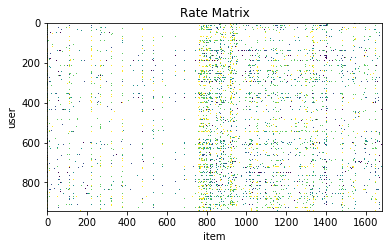

In [7]:
# 빈칸을 힌색, 점수에 색을줌 
plt.imshow(df_table)
plt.grid(False)
plt.xlabel("item")
plt.ylabel("user")
plt.title("Rate Matrix")
plt.show()

## 추천 시스템 알고리즘

1. 베이스라인 모형
2. Collaborative Filtering
    * 2-1. Neighborhood Models
        - User-based CF
        - Item-based CF
    * 2-2. Latent Factor Models
        - Matrix Factorization
        - SVD
3. Content-Based Recommendation


### 베이스라인 모형

사용자 아이디  u , 상품 아이디  i, 두 개의 카테고리 값 입력에서 평점  $r_{ui}$ 의 예측치  $\hat{r}_{ui}$  을 예측하는 가장 단순한 모형

사용자와 상품 특성에 의한 평균 평점의 합을 이용<br>
오차 함수를 최소화 하도록 구해짐 <br>
과최적화를 피하기 위해 정규화 항을 추가 할 수 있다. 

### 최적화 알고리즘 

오차 함수를 최소화하기위한 알고리즘 ( 알고리즘의 선택은 method 인수를 사용)

* ALS (Alternating Least Squares)의 인수
    reg_i: 상품에 대한 정규화 가중치. 디폴트는 10.
    reg_u: 사용자에 대한 정규화 가중치. 디폴트는 15.
    n_epochs: 최적화 반복 횟수. 디폴트는 10.
* SGD (Stochastic Gradient Descent)의 인수
    reg: 정규화 가중치. 디폴트는 0.02.
    learning_rate: 최적화 스텝 사이즈. 디폴트는 0.005.
    n_epochs: 최적화 반복 횟수. 디폴트는 20

### 모형 사용법
1. 데이터세트의 split, folds 메소드를 사용하여 K-Fold 트레이닝 데이터셋과 테스트 데이터셋을 만든다.
2. 모형 알고리즘 객체를 생성한다.
3. 모형 알고리즘 객체의 train 메서드와 트레이닝 데이터셋으로 모수를 추정한 후, test 메서드로 테스트 데이터셋에 대한 예측을 실시한다.
4. accuracy 서브패키지의 성능평가 함수를 사용하여 예측 성능을 계산한다.

evaluate 명령으로 단축할 수도 있다.

베이스라인 모형을 위한 BaselineOnly 클래스

In [32]:
data.split(n_folds=3) # 3개의 fold 로 나눔 
bsl_options = {'method': 'als',
              'n_epochs':5,
              'reg_u': 12, 
              'reg_i':5}
algo = surprise.BaselineOnly(bsl_options=bsl_options)

np.random.seed(0)
acc = np.zeros(3)
for i, (trainset, testset) in enumerate(data.folds()):
#     if i==0 : 
#         print(trainset.all_items)
#         print('-----',trainset)
#         print('-----',testset)
        
    algo.train(trainset)
    predictions = algo.test(testset)
    acc[i] = surprise.accuracy.fcp(predictions, verbose=True)
acc.mean()

Estimating biases using als...
FCP:  0.7047
Estimating biases using als...
FCP:  0.7016
Estimating biases using als...
FCP:  0.6999


0.70206788029453915

 FCP(Fraction of Concordant Pairs)로 계산한 평가 점수는 약 0.70점이다.

### 추천성능 평가기준